In [1]:
import pandas as pd

from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import plotly
from matplotlib import pyplot

import scipy

import os
import re
from pathlib import Path

In [2]:
# setting up directory paths
root = Path("./..").resolve()
exploratory_datasets_path = root / "exploratory_datasets"
cleaned_data = root / "cleaned_data"

assert os.path.exists(exploratory_datasets_path)
assert os.path.exists(cleaned_data)

all_speeches_folder = exploratory_datasets_path / "TXT"
assert os.path.exists(all_speeches_folder)

# 1. Preprocessing

## 1.1. Speeches

### Reading the speech data

In [3]:
folders_to_read = [
    session for
    session in [
        folder for
        folder in os.listdir(all_speeches_folder)
        # skipping over hidden files
        if not folder.startswith(".")
    ]
    # filtering out speeches prior to 2013
    if int(session[-4:]) >= 2013]

folders_to_read.sort(key=lambda x: int(x[-4:]))

all_speeches_to_read = []

for folder in folders_to_read:
    speeches_in_folder = [
        (
            open(all_speeches_folder / folder / speech, 'r').read(), # the actual file content
            speech[0:3], # the iso_3 code
            speech[-8:-4] # the year of the speech
        )
        for speech in os.listdir(all_speeches_folder / folder)
        if not speech.startswith(".")
    ]
    all_speeches_to_read.extend(speeches_in_folder)

all_speeches = pd.DataFrame(all_speeches_to_read)

# deleting speeches list to conserve memory
del all_speeches_to_read

all_speeches.columns = ['text', 'iso_3', 'year']
all_speeches["year"] = all_speeches["year"].astype(int)

Per year, there are between 193 and 196 speeches a year

In [4]:
all_speeches.groupby("year")["text"].count()

year
2013    193
2014    194
2015    193
2016    194
2017    196
2018    196
2019    195
2020    193
2021    194
2022    193
Name: text, dtype: int64

12 countries spoke less than 10 times in the last 10 years (i.e. they didn't speak at all assemblies)

In [5]:
all_speeches.groupby("iso_3")["text"].count()

iso_3
AFG     8
AGO    10
ALB    10
AND    10
ARE    10
       ..
WSM    10
YEM    10
ZAF    10
ZMB    10
ZWE    10
Name: text, Length: 196, dtype: int64

In [6]:
def replace_new_paragraph_line(text: str) -> list[str]:
    """
    function used to naively separate text paragraphs. The splitting criteria is:
    punctuation mark (.!?) followed by a new line and a capital letter.
    :param text: the speech that needs to partitioned.
    :return: Returns a list of speeches split between paragraphs.
    """
    pattern = re.compile("[\.\!\?][\n]+[A-Z]")
    matches = re.finditer(pattern, text)
    positions = [match.start() for match in matches]
    initial_position = 0
    text_list = []
    for end_position in positions[1:]:
        text_list.append(text[initial_position:end_position])
        initial_position = end_position + 2
    text_list.append(text[initial_position:])
    text_list = [text.strip() for text in text_list]
    return text_list

In [7]:
all_speeches["text_split"] = (
    all_speeches['text']
    # splitting all paragraphs into their own text document
    .apply(lambda x: replace_new_paragraph_line(x))
    # removing the first paragraph as it is assumed decorum and does not provide additional information
    .apply(lambda x: x[1:])
)

all_speeches = all_speeches.drop("text", axis=1)

# converting from embedded list structure of paragraphs to row based structure with each observation being a separate paragraph
all_speeches = all_speeches.explode("text_split")

# 1.2. Add codes data set for regions

In [8]:
countries_information = pd.read_csv(exploratory_datasets_path / 'UNSD — Methodology.csv', sep=";")

In [9]:
countries_information = countries_information[['Region Name', 'Sub-region Name', 'ISO-alpha3 Code' ]].rename(columns={'ISO-alpha3 Code':'iso_3'})

## 1.3. Add CO2 emissions per capita information

In [10]:
co2_emissions = pd.read_csv(exploratory_datasets_path / 'co-emissions-per-capita.csv', sep=",", dtype=str)
co2_emissions = co2_emissions.rename(columns={'Code':'iso_3', 'Year':'year'})
co2_emissions['Annual CO₂ emissions (per capita)']=co2_emissions['Annual CO₂ emissions (per capita)'].str.replace(".", "").astype(float)
co2_emissions['year'] = co2_emissions['year'].astype(int)
co2_emissions = co2_emissions[co2_emissions["iso_3"].notna()]

In [11]:
# Adding the difference in CO2 and the CO2 of next year, per country
co2_emissions = co2_emissions.sort_values("year")
co2_emissions["diff_co2"] = (
    co2_emissions
    .groupby(["iso_3"], as_index=False)["Annual CO₂ emissions (per capita)"]
    .rolling(window=2)
    .apply(lambda x: x.iloc[1] - x.iloc[0])
    .drop("iso_3", axis=1)
)

In [12]:
# Adding a shift of the CO2 emissions by year to account for time of emissions report generated and time of the UN General Assembly

co2_emissions['next_year_co2'] = (
    co2_emissions
    .sort_values("year")
    .groupby(["iso_3"], as_index=False)["Annual CO₂ emissions (per capita)"]
    .rolling(window=2).apply(lambda x: x.iloc[1])
    .drop("iso_3", axis=1)
)

In [13]:
co2_emissions.query("year >= 2013")[["Annual CO₂ emissions (per capita)", "diff_co2","next_year_co2"]].describe()

Annual CO₂ emissions (per capita)      diff_co2  next_year_co2
count                       1.980000e+03  1.980000e+03   1.980000e+03
mean                        2.388545e+07  4.628859e+04   2.388545e+07
std                         2.268369e+07  3.010637e+07   2.268369e+07
min                         3.553000e+03 -1.544183e+08   3.553000e+03
25%                         7.254331e+06 -2.458980e+06   7.254331e+06
50%                         1.607286e+07  2.913000e+04   1.607286e+07
75%                         3.526073e+07  2.445591e+06   3.526073e+07
max                         1.558299e+08  1.415930e+08   1.558299e+08

### Europe has the highest CO2

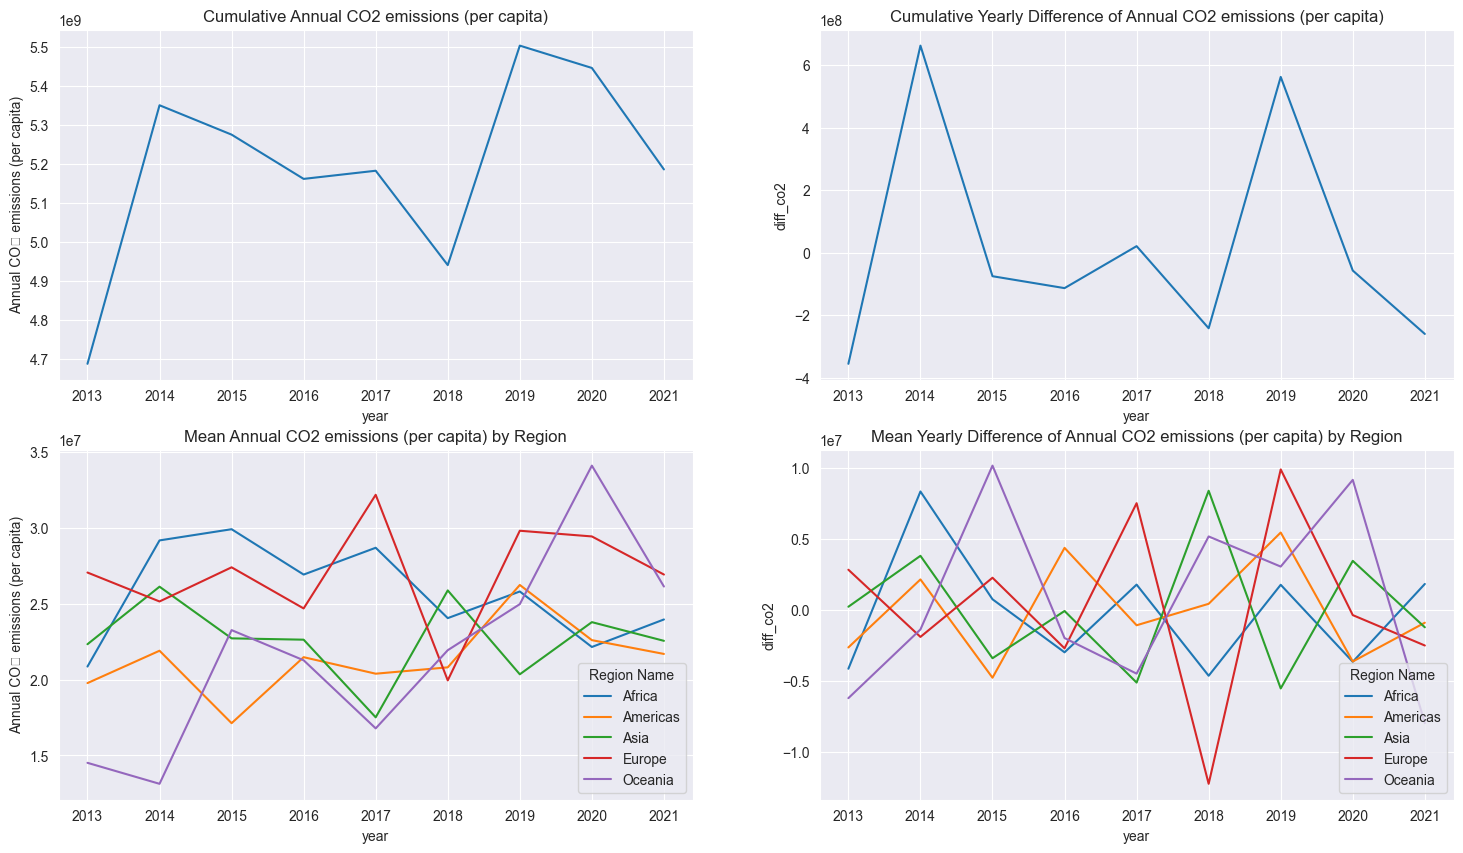

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(2, 2, figsize=(18, 10))

sns.color_palette("pastel")

sns.lineplot(
    ax=ax1,
    data=
    co2_emissions
    .query("year >= 2013")
    .merge(countries_information, on="iso_3")
    .groupby(["year"], as_index=False)["Annual CO₂ emissions (per capita)"]
    .sum(),
    x="year",
    y="Annual CO₂ emissions (per capita)").set(title="Cumulative Annual CO2 emissions (per capita)")

sns.lineplot(
    ax=ax2,
    data=
    co2_emissions
    .query("year >= 2013")
    .merge(countries_information, on="iso_3")
    .groupby(["year"], as_index=False)["diff_co2"]
    .sum(),
    x="year",
    y="diff_co2").set(title="Cumulative Yearly Difference of Annual CO2 emissions (per capita)")

sns.lineplot(
    ax=ax3,
    data=
    co2_emissions
    .query("year >= 2013")
    .merge(countries_information, on="iso_3")
    .groupby(["Region Name", "year"], as_index=False)["Annual CO₂ emissions (per capita)"]
    .mean(),
    x="year",
    y="Annual CO₂ emissions (per capita)",
    hue="Region Name").set(title="Mean Annual CO2 emissions (per capita) by Region")

sns.lineplot(
    ax=ax4,
    data=
    co2_emissions
    .query("year >= 2013")
    .merge(countries_information, on="iso_3")
    .groupby(["Region Name", "year"], as_index=False)["diff_co2"]
    .mean(),
    x="year",
    y="diff_co2",
    hue="Region Name").set(title="Mean Yearly Difference of Annual CO2 emissions (per capita) by Region")

pyplot.show()


# 2. Topic Analysis

In [15]:
texts = all_speeches[all_speeches["text_split"].notna()]["text_split"].to_list()
dates = all_speeches[all_speeches["text_split"].notna()]["year"].to_list()

In [16]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

umap_model =  UMAP(
    n_neighbors=5,
    n_components=15,
    min_dist=0.0,
    metric='cosine',
    random_state=123
    )

hdbscan_model = HDBSCAN(
    min_cluster_size=200,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
    )

ctfidf_model = ClassTfidfTransformer()

keybert = KeyBERTInspired()
mmr = MaximalMarginalRelevance(diversity=0.3)

representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

topic_model = BERTopic(
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  ctfidf_model=ctfidf_model,
  representation_model=representation_model,
  top_n_words=10,
  verbose=True,
  calculate_probabilities=False
)

vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")

In [17]:
topic_model.fit_transform(texts)
topics_per_document = topic_model.get_document_info(texts)
topic_model.update_topics(texts, vectorizer_model=vectorizer_model)

Batches:   0%|          | 0/1338 [00:00<?, ?it/s]

2023-10-02 10:16:19,664 - BERTopic - Transformed documents to Embeddings
2023-10-02 10:17:04,394 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-10-02 10:17:14,216 - BERTopic - Clustered reduced embeddings


In [18]:
topics_over_time = topic_model.topics_over_time(texts, dates, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time)

10it [07:18, 43.87s/it]


In [19]:
topics_per_document = topic_model.get_document_info(texts).query("Topic == 0 or Topic == 2")

In [20]:
topics_per_document.to_parquet(cleaned_data /  "topic_classifications.parquet")

In [21]:
topics_per_document = pd.read_parquet(cleaned_data / "topic_classifications.parquet")

# 3. Sentiment Analysis per paragraph

In [22]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mladenrm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
all_speeches = all_speeches[all_speeches['text_split'].notna()]
all_speeches['sentiment'] = [sia.polarity_scores(paragraph)['compound'] for paragraph in all_speeches['text_split']]

# 4. Merging Data

In [24]:
sentiment_and_topic_speeches = all_speeches.merge(topics_per_document, left_on="text_split", right_on="Document", how="left")
sentiment_and_topic_speeches = sentiment_and_topic_speeches.merge(countries_information, how="left", on="iso_3")

In [25]:
sentiment_and_topic_speeches.head(7)

iso_3  year                                         text_split  sentiment  \
0   MHL  2013  Pacific nations are now dedicated to changing ...     0.7783   
1   MHL  2013  Global efforts on climate change are falling s...    -0.5267   
2   MHL  2013  Our Pacific legacy is not as small island Stat...     0.9620   
3   MHL  2013  Pacific nations, including the States parties ...     0.9678   
4   MHL  2013  Next year’s international meeting on small isl...     0.9637   
5   MHL  2013  But we need not wait for disasters. In every s...     0.9756   
6   MHL  2013  Even as the United Nations enters into a new \...     0.8807   

                                            Document  Topic  \
0  Pacific nations are now dedicated to changing ...    0.0   
1  Global efforts on climate change are falling s...    0.0   
2  Our Pacific legacy is not as small island Stat...    0.0   
3  Pacific nations, including the States parties ...    0.0   
4  Next year’s international meeting on small isl...    0.0   
5                                                NaN    NaN   
6  Even as the United Nations enters into a new \...    2.0   

                                                Name  \
0        0_climate_climate change_change_development   
1        0_climate_climate change_change_development   
2        0_climate_climate change_change_development   
3        0_climate_climate change_change_development   
4        0_climate_climate change_change_development   
5                                                NaN   
6  2_development_sustainable_sustainable developm...   

                                      Representation  \
0  [climate, climate change, change, development,...   
1  [climate, climate change, change, development,...   
2  [climate, climate change, change, development,...   
3  [climate, climate change, change, development,...   
4  [climate, climate change, change, development,...   
5                                                NaN   
6  [development, sustainable, sustainable develop...   

                                             KeyBERT  \
0  [climate, sustainable, emissions, nations, agr...   
1  [climate, sustainable, emissions, nations, agr...   
2  [climate, sustainable, emissions, nations, agr...   
3  [climate, sustainable, emissions, nations, agr...   
4  [climate, sustainable, emissions, nations, agr...   
5                                                NaN   
6  [sustainable, agenda, goals, development, 2030...   

                                                 MMR  \
0  [climate, change, the, to, our, of, and, we, i...   
1  [climate, change, the, to, our, of, and, we, i...   
2  [climate, change, the, to, our, of, and, we, i...   
3  [climate, change, the, to, our, of, and, we, i...   
4  [climate, change, the, to, our, of, and, we, i...   
5                                                NaN   
6  [development, the, sustainable, and, goals, to...   

                                 Representative_Docs  \
0  [Given that the environment is one of the thre...   
1  [Given that the environment is one of the thre...   
2  [Given that the environment is one of the thre...   
3  [Given that the environment is one of the thre...   
4  [Given that the environment is one of the thre...   
5                                                NaN   
6  [We are reminded of those two milestones as we...   

                                         Top_n_words  Probability  \
0  climate - climate change - change - developmen...     1.000000   
1  climate - climate change - change - developmen...     1.000000   
2  climate - climate change - change - developmen...     1.000000   
3  climate - climate change - change - developmen...     1.000000   
4  climate - climate change - change - developmen...     1.000000   
5                                                NaN          NaN   
6  development - sustainable - sustainable develo...     0.873775   

  Representative_document Region Name Sub-region Name  
0         

Overall Sentiment over the years

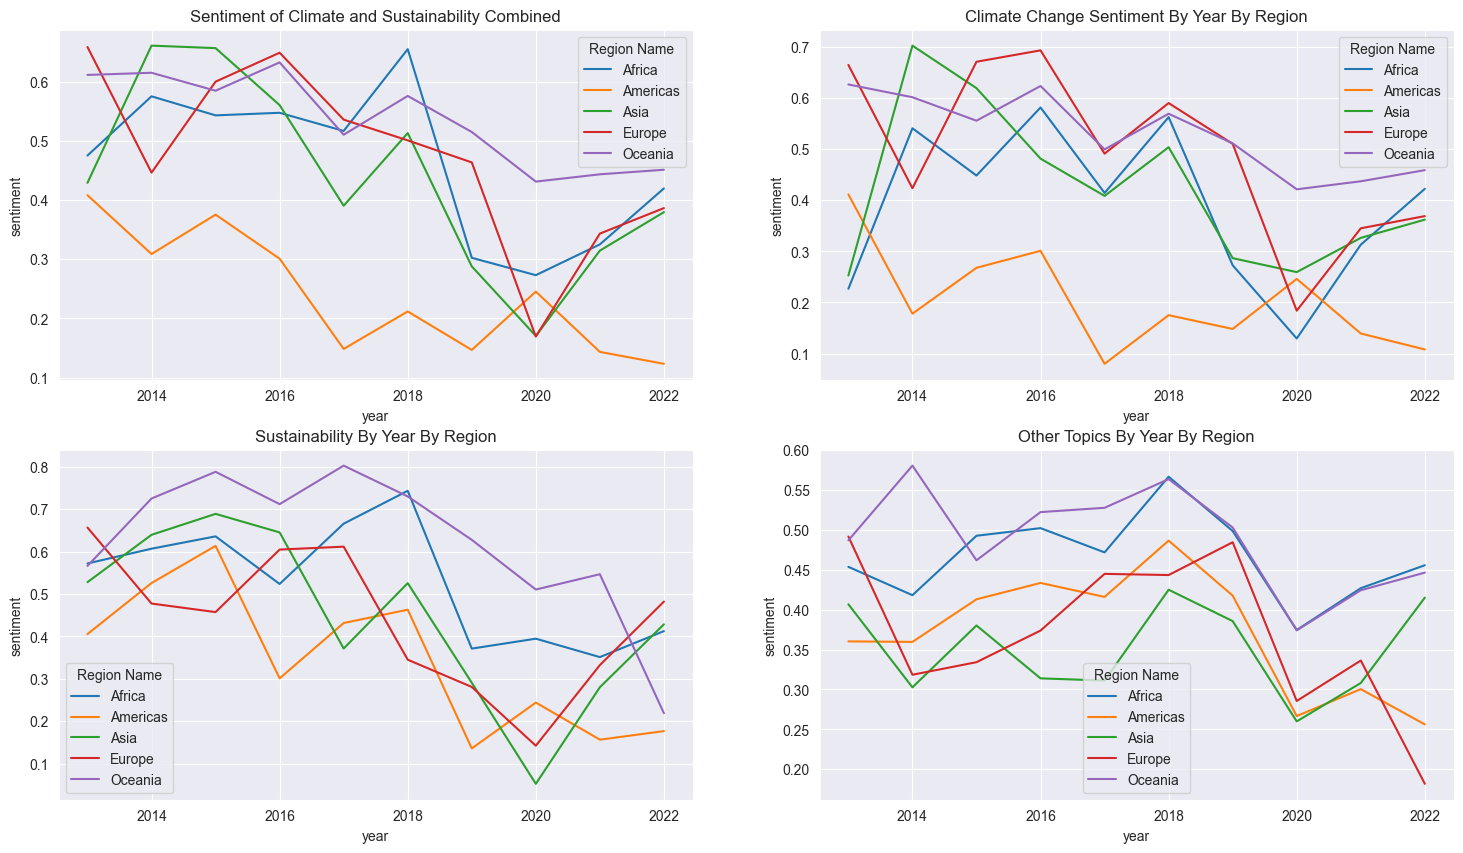

In [26]:
fig, axes = pyplot.subplots(2, 2, figsize=(18, 10))

sns.color_palette("pastel")

sns.lineplot(
    ax=axes[0, 0],
    data=sentiment_and_topic_speeches
    .query("Topic == 0 | Topic == 2")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean(),
    x="year",
    y="sentiment",
    hue="Region Name").set(title="Sentiment of Climate and Sustainability Combined")

sns.lineplot(
    ax=axes[0, 1],
    data=sentiment_and_topic_speeches
    .query("Topic == 0")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean(),
    x="year",
    y="sentiment",
    hue="Region Name").set(title="Climate Change Sentiment By Year By Region")

sns.lineplot(
    ax=axes[1, 0],
    data=
    sentiment_and_topic_speeches
    .query("Topic == 2")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean(),
    x="year",
    y="sentiment",
    hue="Region Name").set(title="Sustainability By Year By Region")

sns.lineplot(
    ax=axes[1, 1],
    data=
    sentiment_and_topic_speeches
    .query("Topic.isnull()")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean(),
    x="year",
    y="sentiment",
    hue="Region Name").set(title="Other Topics By Year By Region")

pyplot.show()

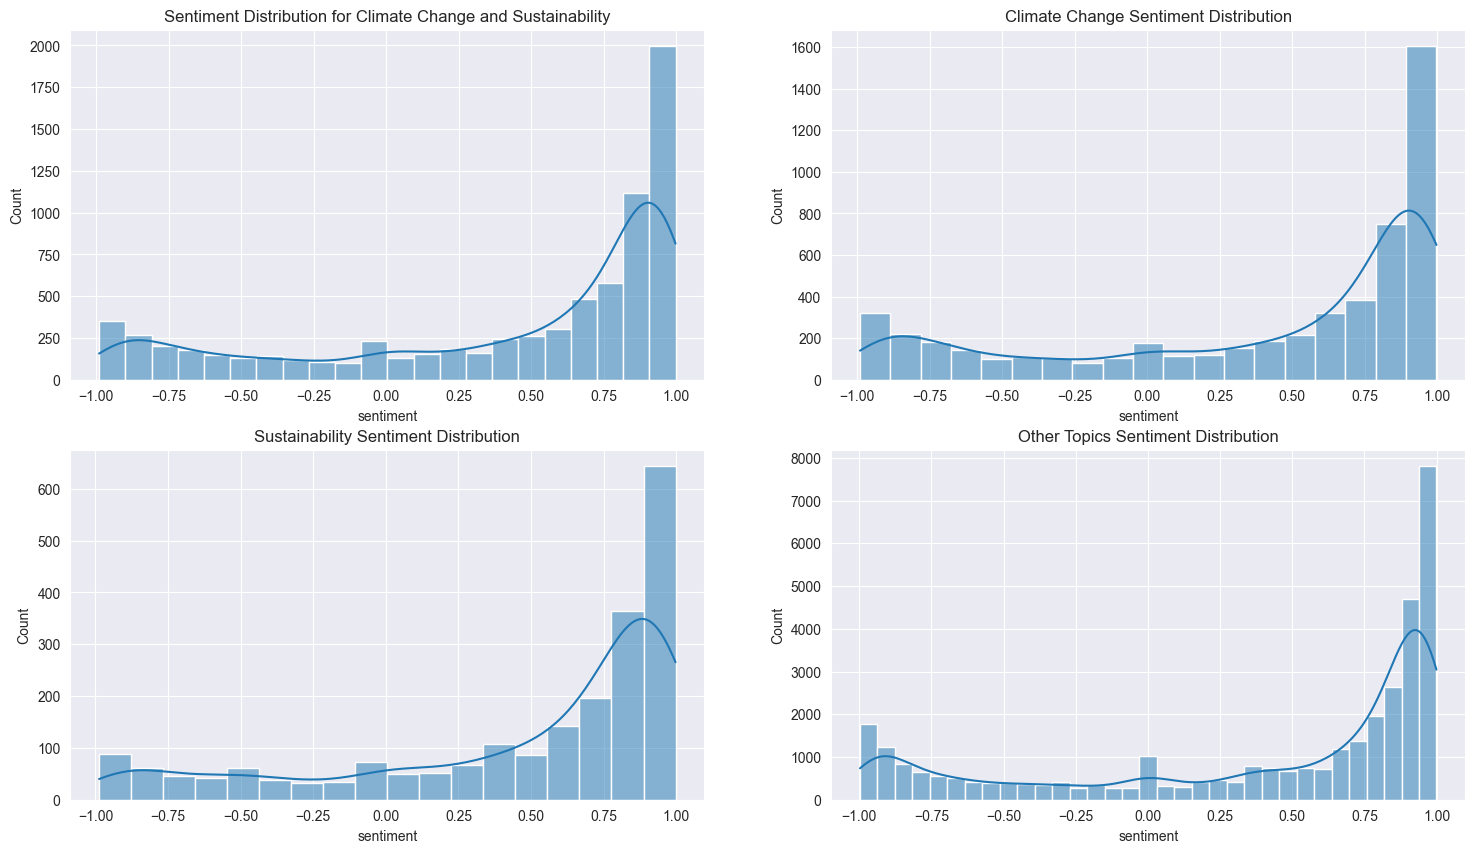

In [27]:
fig, axes = pyplot.subplots(2, 2, figsize=(18, 10))

sns.color_palette("pastel")

sns.histplot(
    ax=axes[0, 0],
    data=sentiment_and_topic_speeches
    .query("Topic == 0 | Topic == 2"),
    kde=True,
    x="sentiment").set(title="Sentiment Distribution for Climate Change and Sustainability")

sns.histplot(
    ax=axes[0, 1],
    data=sentiment_and_topic_speeches
    .query("Topic == 0"),
    kde=True,
    x="sentiment").set(title="Climate Change Sentiment Distribution")

sns.histplot(
    ax=axes[1, 0],
    data=
    sentiment_and_topic_speeches
    .query("Topic == 2"),
    kde=True,
    x="sentiment").set(title="Sustainability Sentiment Distribution")

sns.histplot(
    ax=axes[1, 1],
    data=
    sentiment_and_topic_speeches
    .query("Topic.isnull()"),
    kde=True,
    x="sentiment").set(title="Other Topics Sentiment Distribution")

pyplot.show()

#

In [28]:
sentiments_per_topic_general_info = sentiment_and_topic_speeches.groupby(['Topic'], as_index=False, dropna=False)['sentiment'].describe()
sentiments_per_topic_general_info

Topic    count      mean       std     min     25%     50%     75%     max
0    0.0   5377.0  0.383178  0.653527 -0.9902 -0.0516  0.7003  0.9153  0.9975
1    2.0   2189.0  0.457973  0.587264 -0.9873  0.1531  0.7269  0.9062  0.9973
2    NaN  35247.0  0.382801  0.676525 -0.9974 -0.0772  0.7351  0.9287  0.9997

#### Since our histograms show a distribution of sentiments that is very far from normal and extremely skewed, to check if the distributions of climate change sentiment, sustainability sentiment and other topics is different we can run a Wilcoxon Ranked Sum Test.

The test <span style="color:red">failed to reject</span> that there is a significant difference between the distributions of Sentiment for Climate Change and Sustainability.
The test <span style="color:red">failed to reject</span> that there is a significant difference between the distributions of Sentiment for Climate Change and Other Topics.
The test <span style="color:red">rejected</span> no significant difference between the distributions of Sentiment for Sustainability and Other Topics.
The test <span style="color:red">failed to reject</span> that there is a significant difference between the distributions of Sentiment for Climate Change and Sustainability Combined and Other Topics.


In [29]:
compare_climate_change_sustainability = scipy.stats.ranksums(
    sentiment_and_topic_speeches
    .query("Topic == 0")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    sentiment_and_topic_speeches
    .query("Topic == 2")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    alternative='two-sided'
)

compare_climate_change_other_topics = scipy.stats.ranksums(
    sentiment_and_topic_speeches
    .query("Topic == 0")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    sentiment_and_topic_speeches
    .query("Topic.isnull()")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    alternative='two-sided'
)

compare_sustainability_other_topics = scipy.stats.ranksums(
    sentiment_and_topic_speeches
    .query("Topic == 2")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    sentiment_and_topic_speeches
    .query("Topic.isnull()")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    alternative='two-sided'
)

compare_climate_and_sustainability_other_topics = scipy.stats.ranksums(
    sentiment_and_topic_speeches
    .query("Topic == 2 | Topic == 0")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    sentiment_and_topic_speeches
    .query("Topic.isnull()")
    .groupby(['Region Name', 'year'], as_index=False)['sentiment'].mean()['sentiment'],
    alternative='two-sided'
)

print(compare_climate_change_sustainability)
print(compare_climate_change_other_topics)
print(compare_sustainability_other_topics)
print(compare_climate_and_sustainability_other_topics)

RanksumsResult(statistic=-1.8682251862488777, pvalue=0.06173068956651762)
RanksumsResult(statistic=0.1585578571355136, pvalue=0.8740172337930099)
RanksumsResult(statistic=2.2473852793990186, pvalue=0.024615414964175148)
RanksumsResult(statistic=1.2064184782049947, pvalue=0.22765617476544375)


In [30]:
mean_overall_sentiment = (
    sentiment_and_topic_speeches
    .groupby(["iso_3", "year"], as_index=False)["sentiment"]
    .mean()
    .rename(columns={"sentiment": "mean_overall_sentiment"})
)
mean_climate_sentiment = (
    sentiment_and_topic_speeches
    .query("Topic == 0")
    .groupby(["iso_3", "year"], as_index=False)["sentiment"]
    .mean()
    .rename(columns={"sentiment": "mean_climate_sentiment"})
)
mean_sustainability_sentiment = (
    sentiment_and_topic_speeches
    .query("Topic == 2")
    .groupby(["iso_3", "year"], as_index=False)["sentiment"]
    .mean()
    .rename(columns={"sentiment": "mean_sustainability_sentiment"})
)
mean_climate_sustainability_sentiment = (
    sentiment_and_topic_speeches
    .query("Topic == 0 | Topic == 2")
    .groupby(["iso_3", "year"], as_index=False)["sentiment"]
    .mean()
    .rename(columns={"sentiment": "mean_climate_sustainability_sentiment"})
)

mean_sentiment_score = (
    mean_overall_sentiment
    .merge(mean_climate_sentiment, on=["iso_3", "year"], how="left")
    .merge(mean_sustainability_sentiment, on=["iso_3", "year"], how="left")
    .merge(mean_climate_sustainability_sentiment, on=["iso_3", "year"], how="left")
    .fillna(0)
)

del mean_climate_sentiment
del mean_sustainability_sentiment
del mean_climate_sustainability_sentiment

## Creating Ratios between total count of paragraphs and count of paragraphs discussing climate change, sustainability and both climate change and sustainability

In [31]:
total_paragraphs = (
    sentiment_and_topic_speeches
    .groupby(["iso_3", "year"], as_index = False)["sentiment"]
    .count()
    .rename(columns={"sentiment": "total_paragraphs"})
)
climate_change_paragraphs = (
    sentiment_and_topic_speeches
    .query(" Topic == 0")
    .groupby(["iso_3", "year"], as_index = False, observed=False)["sentiment"]
    .count()
    .rename(columns={"sentiment": "climate_paragraphs"})
)

sustainability_change_paragraphs = (
    sentiment_and_topic_speeches
    .query(" Topic == 2")
    .groupby(["iso_3", "year"], as_index = False, observed=False)["sentiment"]
    .count()
    .rename(columns={"sentiment": "sustainability_paragraphs"})
)

climate_sustainability_change_paragraphs = (
    sentiment_and_topic_speeches
    .query(" Topic == 0 | Topic == 2")
    .groupby(["iso_3", "year"], as_index = False, observed=False)["sentiment"]
    .count()
    .rename(columns={"sentiment": "climate_sustainability_change_paragraphs"})
)

talks_combined = (
    total_paragraphs
    .merge(climate_change_paragraphs, on=["iso_3", "year"], how='left')
    .merge(sustainability_change_paragraphs,  on=["iso_3", "year"], how='left')
    .merge(climate_sustainability_change_paragraphs,  on=["iso_3", "year"], how='left')
    .fillna(0)
)

talks_combined["time_spent_on_climate"] = talks_combined.apply(
    lambda x: x["climate_paragraphs"] / x["total_paragraphs"],
    axis=1
)
talks_combined["time_spent_on_sustainability"] = talks_combined.apply(
    lambda x: x["sustainability_paragraphs"] / x["total_paragraphs"],
    axis=1
)
talks_combined["time_spent_on_sustainability_climate"] = talks_combined.apply(
    lambda x: x["climate_sustainability_change_paragraphs"] / x["total_paragraphs"],
    axis=1
)

talks_combined["diff_time_spent_climate"] = (
    talks_combined
    .sort_values("year")
    .groupby(["iso_3"], as_index=False)["time_spent_on_climate"]
    .rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
    .fillna(0)
    .drop("iso_3", axis=1)
)

talks_combined["diff_time_spent_sustinability"] = (
    talks_combined
    .sort_values("year")
    .groupby(["iso_3"], as_index=False)["time_spent_on_sustainability"]
    .rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
    .fillna(0)
    .drop("iso_3", axis=1)
)

talks_combined["diff_time_spent_climate_sustainability"] = (
    talks_combined
    .sort_values("year")
    .groupby(["iso_3"], as_index=False)["time_spent_on_sustainability_climate"]
    .rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
    .fillna(0)
    .drop("iso_3", axis=1)
)

del total_paragraphs
del climate_change_paragraphs
del sustainability_change_paragraphs

In [32]:
sentiment_and_topic_speeches.to_parquet(cleaned_data / "sentiment_and_topic_speeches.parquet")
del sentiment_and_topic_speeches

In [33]:
mean_sentiment_score = mean_sentiment_score.merge(talks_combined, how="left", on=["iso_3", "year"])

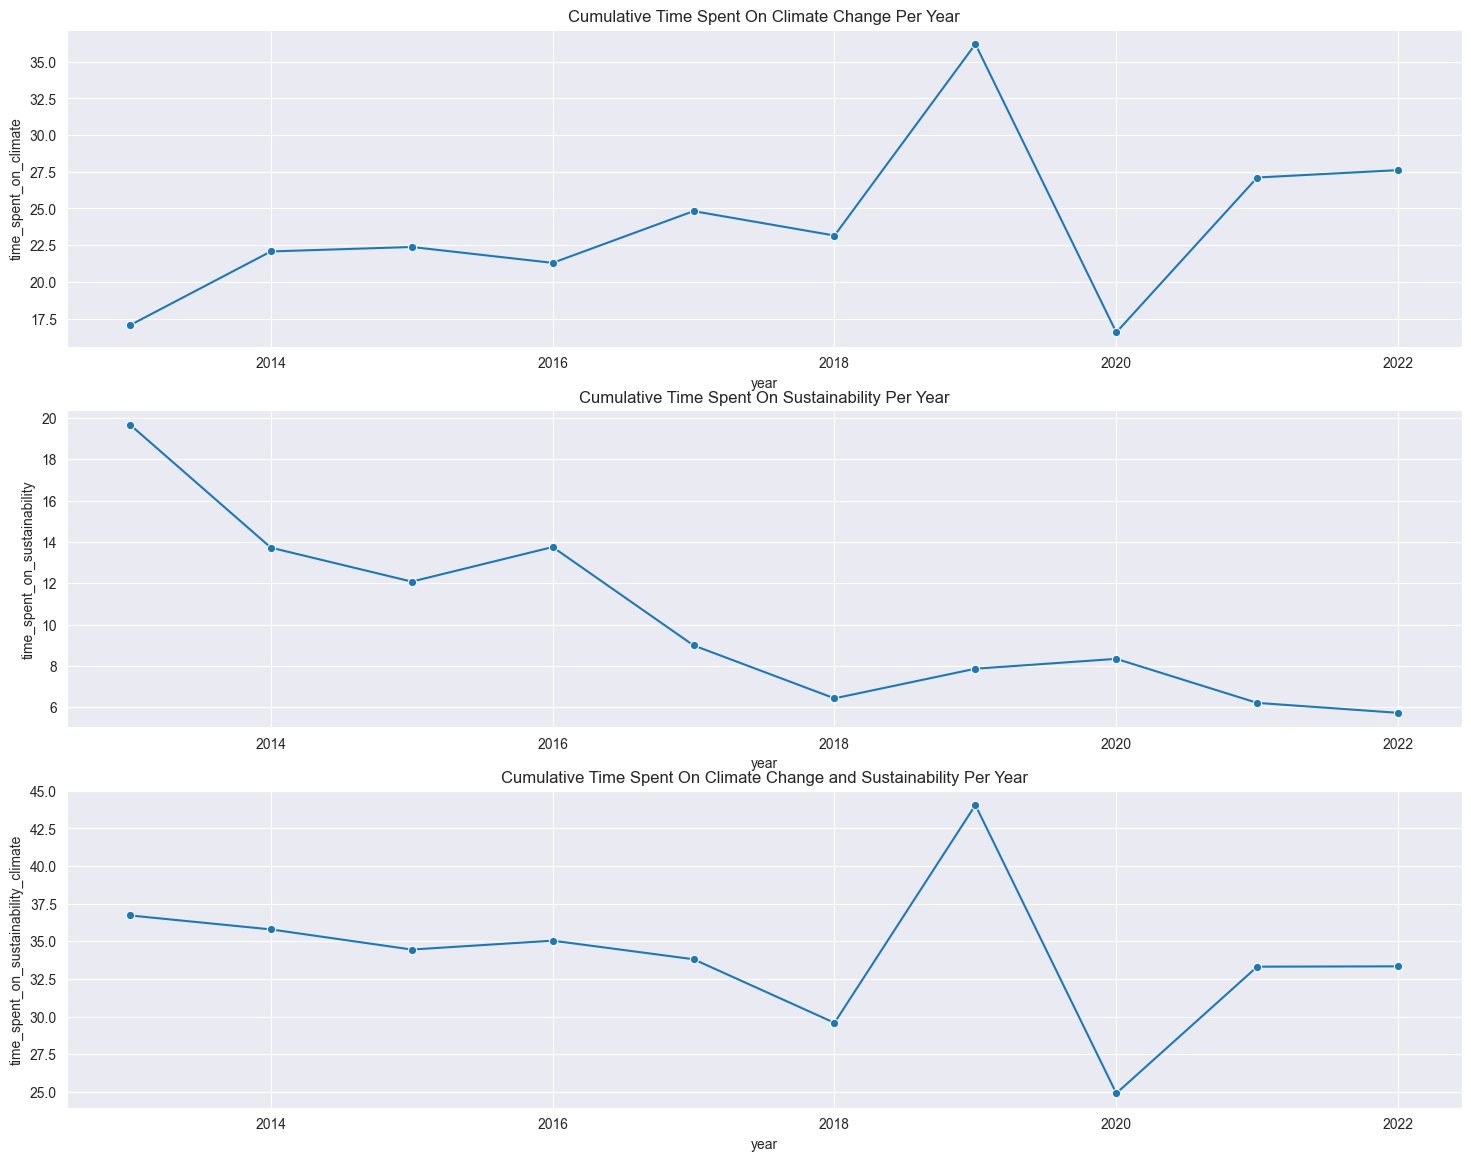

In [34]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3, figsize=(18, 14))

sns.color_palette("pastel")

sns.lineplot(
    ax=ax1,
    data=mean_sentiment_score.groupby('year', as_index=False)['time_spent_on_climate'].sum(),
    x="year",
    y="time_spent_on_climate",
    marker='o'
).set(title="Cumulative Time Spent On Climate Change Per Year")

sns.lineplot(
    ax=ax2,
    data=mean_sentiment_score.groupby('year', as_index=False)['time_spent_on_sustainability'].sum(),
    x="year",
    y="time_spent_on_sustainability",
    marker='o'
).set(title="Cumulative Time Spent On Sustainability Per Year")

sns.lineplot(
    ax=ax3,
    data=mean_sentiment_score.groupby('year', as_index=False)['time_spent_on_sustainability_climate'].sum(),
    x="year",
    y="time_spent_on_sustainability_climate",
    marker='o'
).set(title="Cumulative Time Spent On Climate Change and Sustainability Per Year")

pyplot.show()

### Merging sentiment scores and co2 emissions data

In [35]:
mean_sentiment_score = mean_sentiment_score.merge(co2_emissions, on=["iso_3", "year"], how="left")

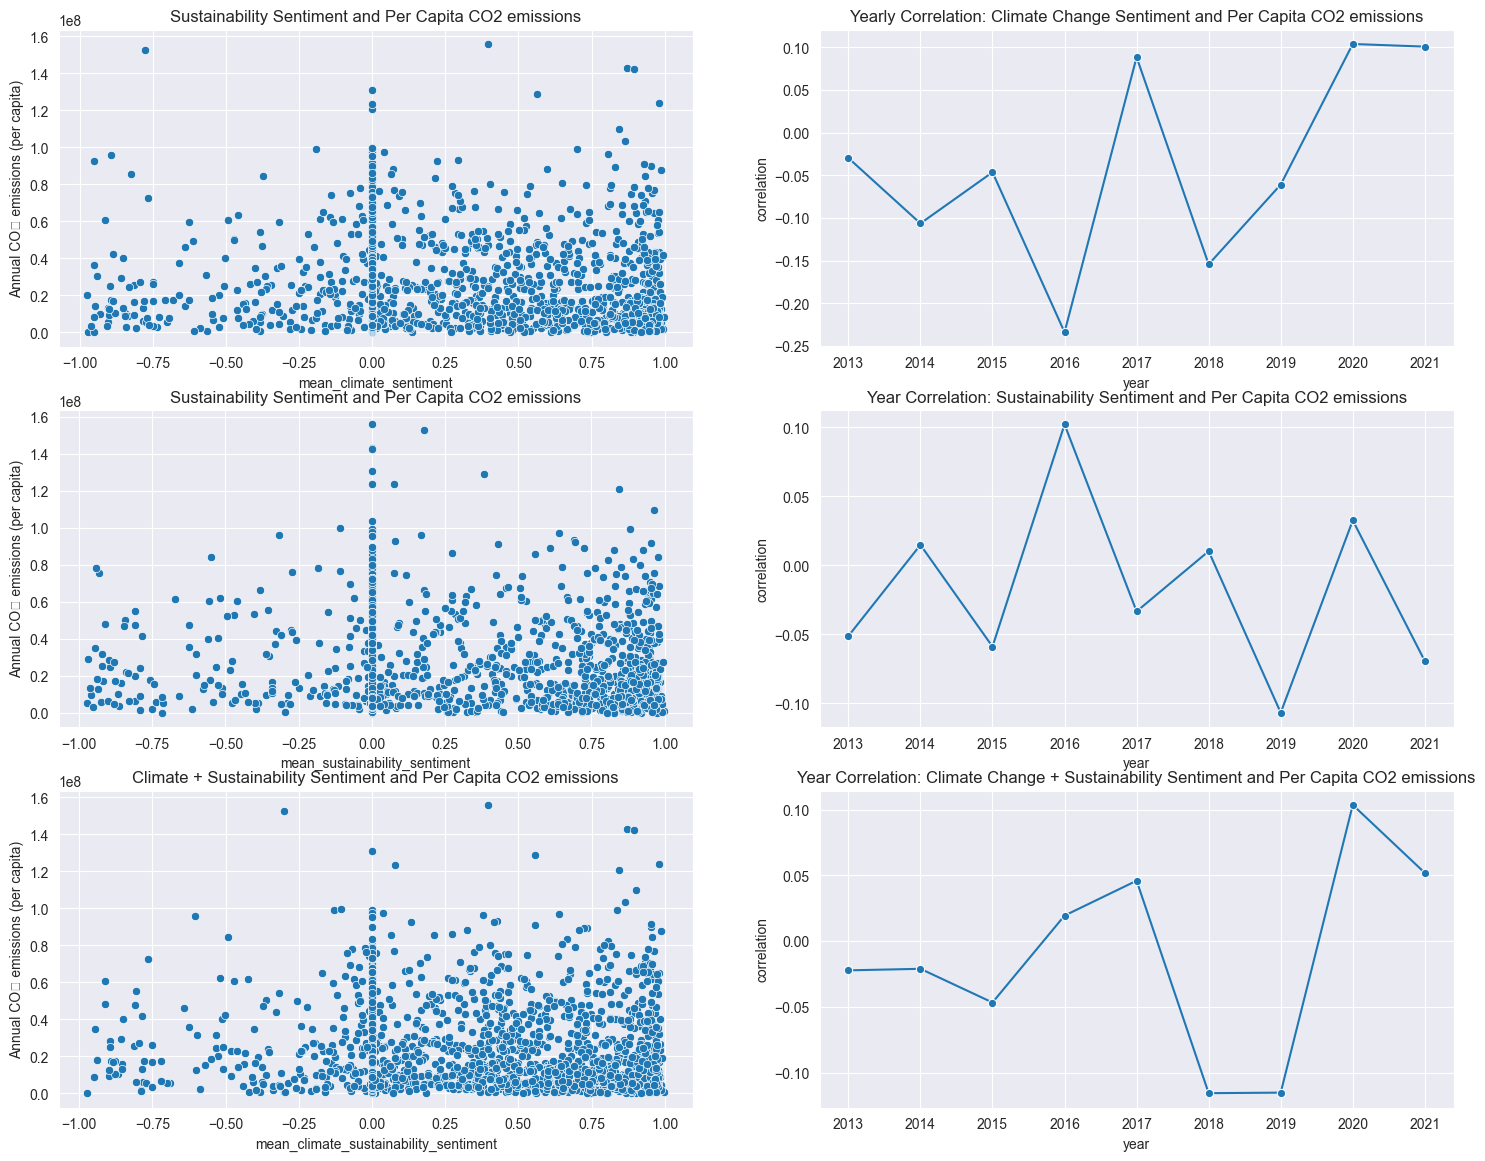

In [36]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pyplot.subplots(3, 2, figsize=(18, 14))

sns.color_palette("pastel")

sns.scatterplot(
    ax=ax1,
    data=mean_sentiment_score,
    x="mean_climate_sentiment",
    y="Annual CO₂ emissions (per capita)",
).set(title="Sustainability Sentiment and Per Capita CO2 emissions")

sns.lineplot(
    ax=ax2,
    data=mean_sentiment_score
         .groupby('year')[['mean_climate_sentiment', 'Annual CO₂ emissions (per capita)']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'Annual CO₂ emissions (per capita)': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Yearly Correlation: Climate Change Sentiment and Per Capita CO2 emissions")

sns.scatterplot(
    ax=ax3,
    data=mean_sentiment_score,
    x="mean_sustainability_sentiment",
    y="Annual CO₂ emissions (per capita)",
).set(title="Sustainability Sentiment and Per Capita CO2 emissions")

sns.lineplot(
    ax=ax4,
    data=mean_sentiment_score
         .groupby('year')[['mean_sustainability_sentiment', 'Annual CO₂ emissions (per capita)']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'Annual CO₂ emissions (per capita)': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Year Correlation: Sustainability Sentiment and Per Capita CO2 emissions")

sns.scatterplot(
    ax=ax5,
    data=mean_sentiment_score,
    x="mean_climate_sustainability_sentiment",
    y="Annual CO₂ emissions (per capita)",
).set(title="Climate + Sustainability Sentiment and Per Capita CO2 emissions")

sns.lineplot(
    ax=ax6,
    data=mean_sentiment_score
         .groupby('year')[['mean_climate_sustainability_sentiment', 'Annual CO₂ emissions (per capita)']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'Annual CO₂ emissions (per capita)': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Year Correlation: Climate Change + Sustainability Sentiment and Per Capita CO2 emissions")

pyplot.show()

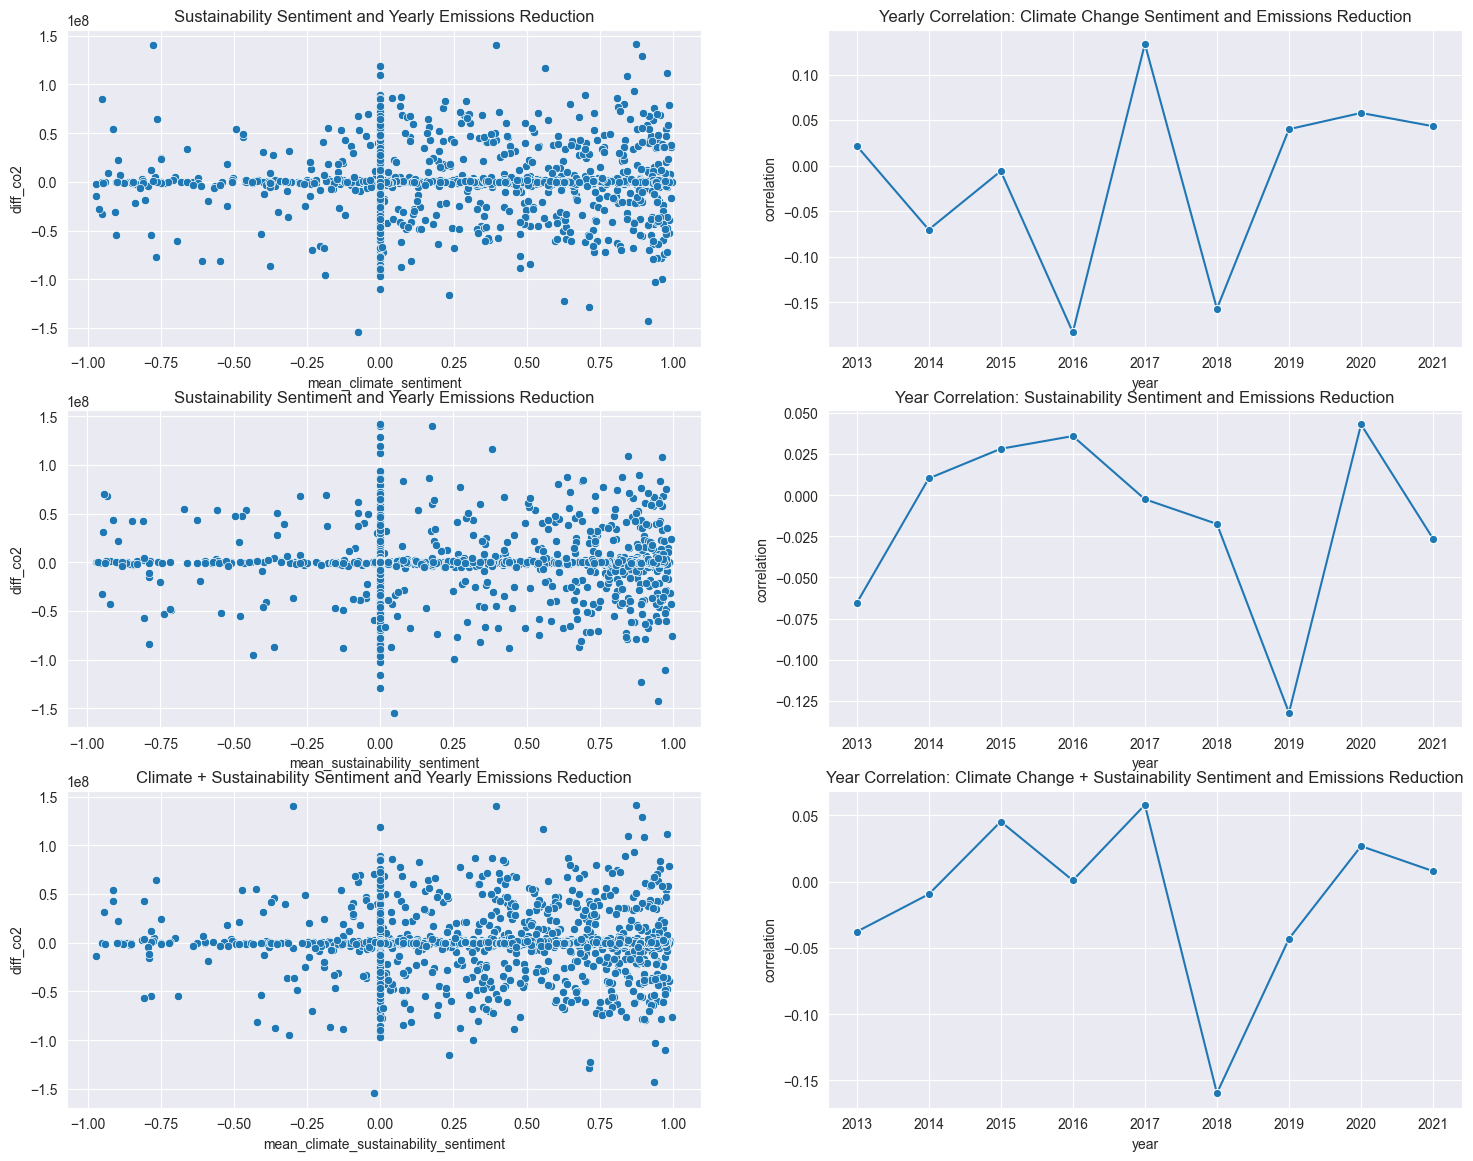

In [37]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pyplot.subplots(3, 2, figsize=(18, 14))

sns.color_palette("pastel")

sns.scatterplot(
    ax=ax1,
    data=mean_sentiment_score,
    x="mean_climate_sentiment",
    y="diff_co2",
).set(title="Sustainability Sentiment and Yearly Emissions Reduction")

sns.lineplot(
    ax=ax2,
    data=mean_sentiment_score
         .groupby('year')[['mean_climate_sentiment', 'diff_co2']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'diff_co2': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Yearly Correlation: Climate Change Sentiment and Emissions Reduction")

sns.scatterplot(
    ax=ax3,
    data=mean_sentiment_score,
    x="mean_sustainability_sentiment",
    y="diff_co2",
).set(title="Sustainability Sentiment and Yearly Emissions Reduction")

sns.lineplot(
    ax=ax4,
    data=mean_sentiment_score
         .groupby('year')[['mean_sustainability_sentiment', 'diff_co2']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'diff_co2': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Year Correlation: Sustainability Sentiment and Emissions Reduction")

sns.scatterplot(
    ax=ax5,
    data=mean_sentiment_score,
    x="mean_climate_sustainability_sentiment",
    y="diff_co2",
).set(title="Climate + Sustainability Sentiment and Yearly Emissions Reduction")

sns.lineplot(
    ax=ax6,
    data=mean_sentiment_score
         .groupby('year')[['mean_climate_sustainability_sentiment', 'diff_co2']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'diff_co2': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Year Correlation: Climate Change + Sustainability Sentiment and Emissions Reduction")

pyplot.show()

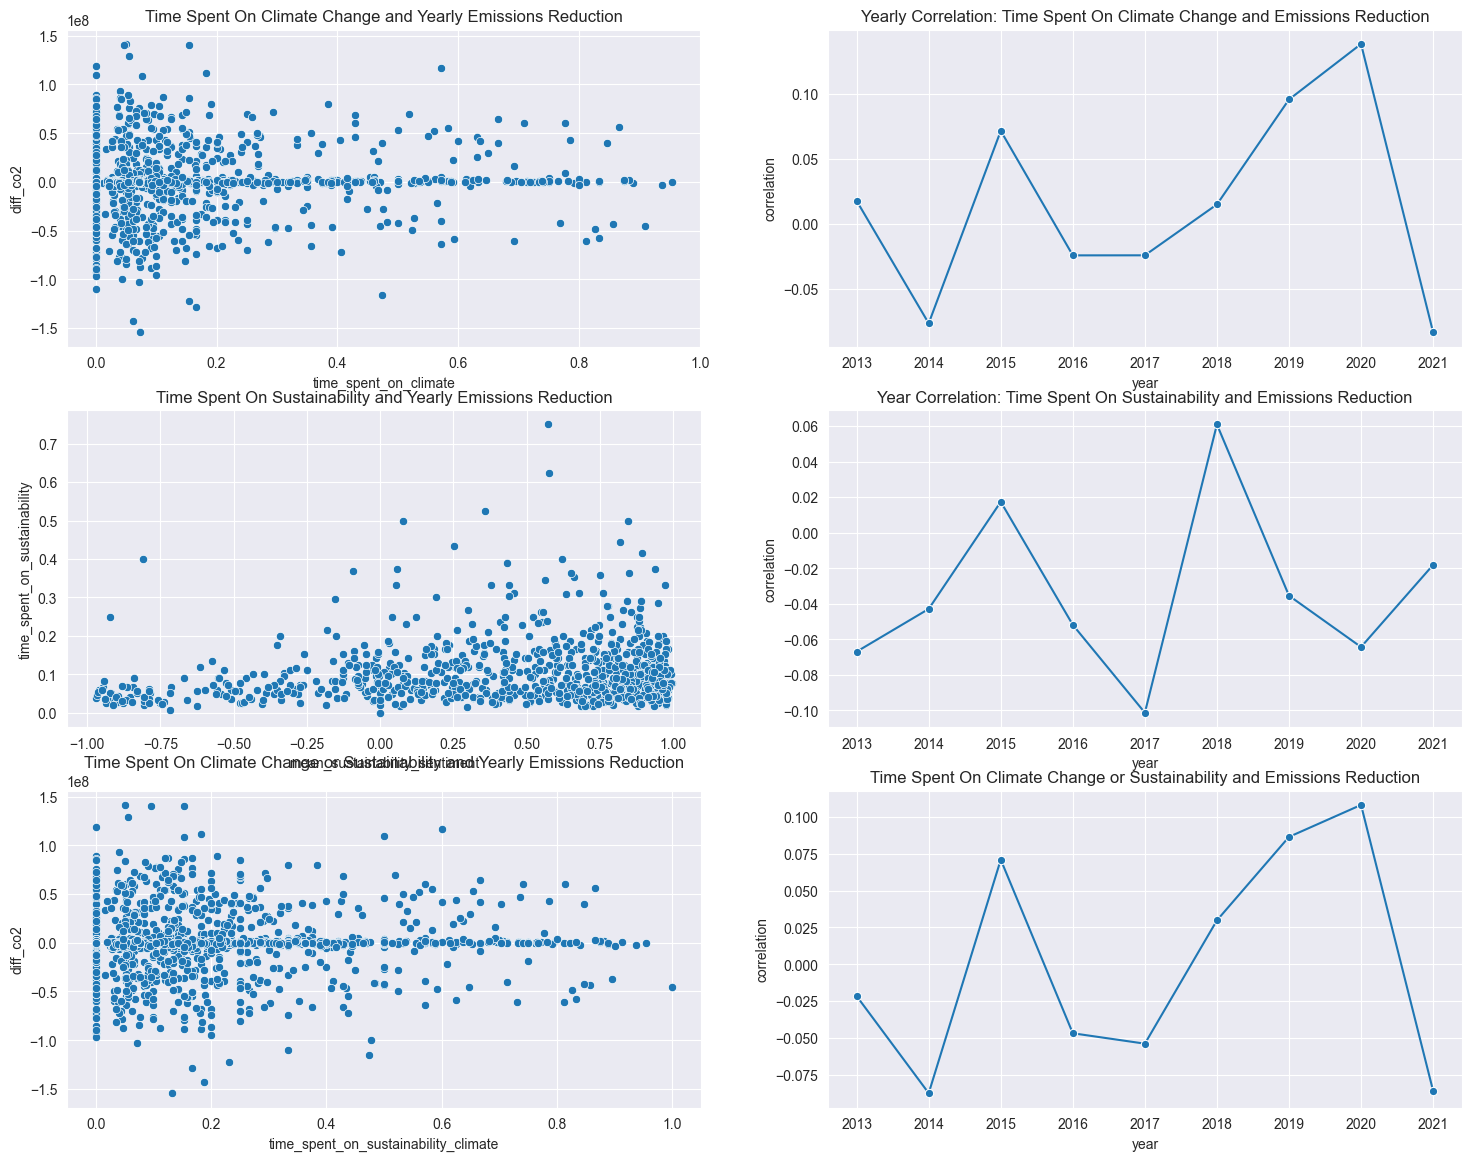

In [65]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pyplot.subplots(3, 2, figsize=(18, 14))

sns.color_palette("pastel")

sns.scatterplot(
    ax=ax1,
    data=mean_sentiment_score,
    x="time_spent_on_climate",
    y="diff_co2",
).set(title="Time Spent On Climate Change and Yearly Emissions Reduction")

sns.lineplot(
    ax=ax2,
    data=mean_sentiment_score
         .groupby('year')[['time_spent_on_climate', 'diff_co2']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'diff_co2': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Yearly Correlation: Time Spent On Climate Change and Emissions Reduction")

sns.scatterplot(
    ax=ax3,
    data=mean_sentiment_score,
    x="mean_sustainability_sentiment",
    y="time_spent_on_sustainability",
).set(title="Time Spent On Sustainability and Yearly Emissions Reduction")

sns.lineplot(
    ax=ax4,
    data=mean_sentiment_score
         .groupby('year')[['time_spent_on_sustainability', 'diff_co2']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'diff_co2': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Year Correlation: Time Spent On Sustainability and Emissions Reduction")

sns.scatterplot(
    ax=ax5,
    data=mean_sentiment_score,
    x="time_spent_on_sustainability_climate",
    y="diff_co2",
).set(title="Time Spent On Climate Change or Sustainability and Yearly Emissions Reduction")

sns.lineplot(
    ax=ax6,
    data=mean_sentiment_score
         .groupby('year')[['time_spent_on_sustainability_climate', 'diff_co2']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'diff_co2': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Time Spent On Climate Change or Sustainability and Emissions Reduction")

pyplot.show()

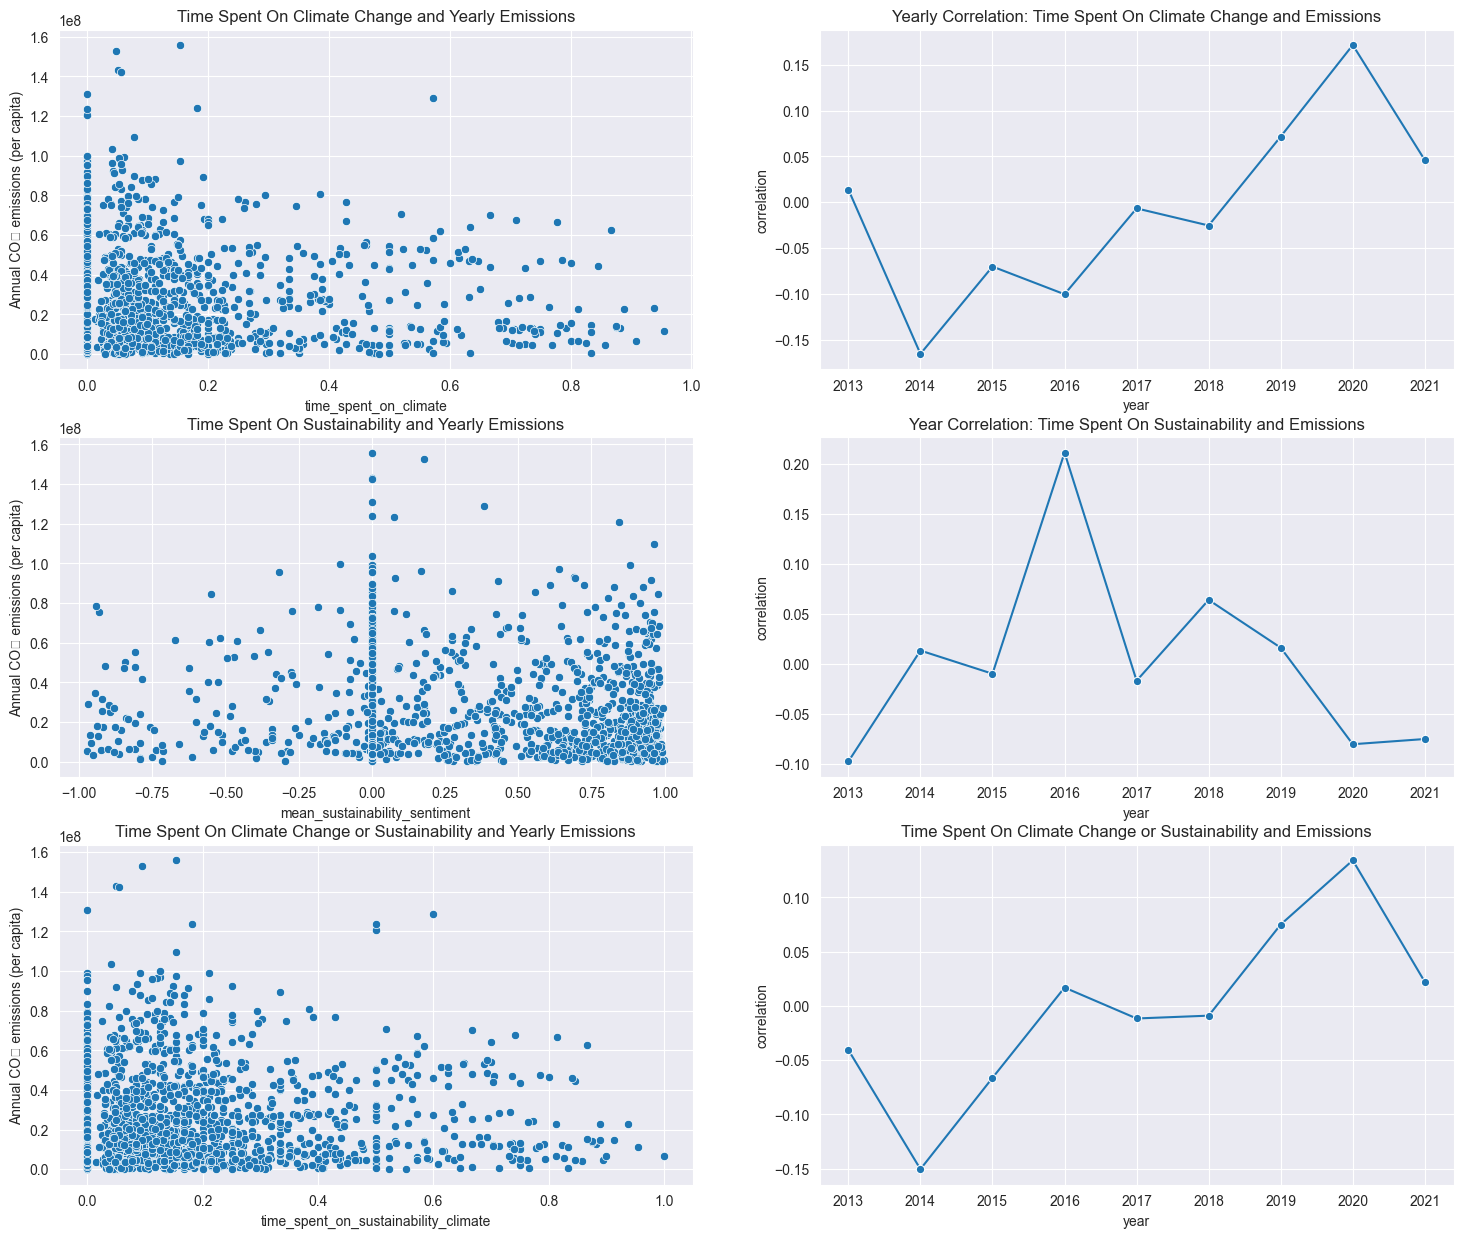

In [69]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pyplot.subplots(3, 2, figsize=(18, 15))

sns.color_palette("pastel")

sns.scatterplot(
    ax=ax1,
    data=mean_sentiment_score,
    x="time_spent_on_climate",
    y="Annual CO₂ emissions (per capita)",
).set(title="Time Spent On Climate Change and Yearly Emissions")

sns.lineplot(
    ax=ax2,
    data=mean_sentiment_score
         .groupby('year')[['time_spent_on_climate', 'Annual CO₂ emissions (per capita)']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'Annual CO₂ emissions (per capita)': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Yearly Correlation: Time Spent On Climate Change and Emissions")

sns.scatterplot(
    ax=ax3,
    data=mean_sentiment_score,
    x="mean_sustainability_sentiment",
    y='Annual CO₂ emissions (per capita)',
).set(title="Time Spent On Sustainability and Yearly Emissions")

sns.lineplot(
    ax=ax4,
    data=mean_sentiment_score
         .groupby('year')[['time_spent_on_sustainability', 'Annual CO₂ emissions (per capita)']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'Annual CO₂ emissions (per capita)': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Year Correlation: Time Spent On Sustainability and Emissions")

sns.scatterplot(
    ax=ax5,
    data=mean_sentiment_score,
    x="time_spent_on_sustainability_climate",
    y="Annual CO₂ emissions (per capita)",
).set(title="Time Spent On Climate Change or Sustainability and Yearly Emissions")

sns.lineplot(
    ax=ax6,
    data=mean_sentiment_score
         .groupby('year')[['time_spent_on_sustainability_climate', 'Annual CO₂ emissions (per capita)']]
         .corr().iloc[0::2,-1]
         .reset_index()
         .rename(columns={'Annual CO₂ emissions (per capita)': 'correlation'}),
    x="year",
    y="correlation",
    marker='o'
).set(title="Time Spent On Climate Change or Sustainability and Emissions")

pyplot.show()

In [38]:
mean_sentiment_score = mean_sentiment_score.merge(countries_information, on="iso_3", how="left")

In [56]:
mean_sentiment_score = mean_sentiment_score.dropna(subset=["Annual CO₂ emissions (per capita)"])

In [39]:
df_ccc = mean_sentiment_score.groupby(['Region Name'], as_index=False)['time_spent_on_climate'].mean()

data = [dict(type='choropleth',
            locations = df_ccc['iso_3'],
            z=df_ccc['time_spent_on_climate'])]

layout = dict(geo=dict(scope='world'))

fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig)

KeyError: 'iso_3'

In [ ]:
df_ccc = mean_sentiment_score.groupby(['Region  Name'], as_index=False)['time_spent_on_sustainability'].mean()

data = [dict(type='choropleth',
            locations = df_ccc['iso_3'],
            z=df_ccc['time_spent_on_sustainability'])]

layout = dict(geo=dict(scope='world'))

fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig)

In [ ]:
df_ccc = mean_sentiment_score.groupby(['Region  Name'], as_index=False)['time_spent_on_sustainability_climate'].mean()

data = [dict(type='choropleth',
            locations = df_ccc['iso_3'],
            z=df_ccc['time_spent_on_sustainability_climate'])]

layout = dict(geo=dict(scope='world'))

fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig)

# Predictions

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import (
    PowerTransformer,
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import make_column_selector, make_column_transformer

features = [
    'Region Name',
    'Entity',
    'year',
    'mean_climate_sentiment',
    'mean_sustainability_sentiment',
    'mean_climate_sustainability_sentiment',
    'time_spent_on_climate',
    'time_spent_on_sustainability',
    'time_spent_on_sustainability_climate'
]

predictors_training, predictors_test, outcome_training, outcome_test = train_test_split(
    mean_sentiment_score.loc[:, features],
    mean_sentiment_score.loc[:, 'Annual CO₂ emissions (per capita)'],
    random_state=0,
    test_size=0.2
)


power_and_one_hot_transforms = make_column_transformer(
        (OneHotEncoder(), ["Region Name", "Entity"]),
        (PowerTransformer(), make_column_selector(pattern=r"sentiment")),
        (PowerTransformer(), make_column_selector(pattern=r"time_spent_on")),
        remainder='passthrough'
    )

standard_scale_and_one_hot_transforms = make_column_transformer(
        (OneHotEncoder(), ["Region Name", "Entity"]),
        (StandardScaler(), make_column_selector(pattern=r"sentiment")),
        (StandardScaler(), make_column_selector(pattern=r"time_spent_on")),
        remainder='passthrough'
    )

one_hot_encode_only = make_column_transformer(
        (OneHotEncoder(), ["Region Name", "Entity"]),
        remainder='passthrough'
    )

polynomial_features = PolynomialFeatures()

regression_model = LinearRegression()
lasso_model = Ridge(max_iter=10_000)

model_pipeline = Pipeline(
        [
            ("column_transformation", power_and_one_hot_transforms),
            ("polynomial_features", polynomial_features),
            ("linear_regression", regression_model),
        ]
    )

tuning_standard_model = {
    "column_transformation": [power_and_one_hot_transforms, standard_scale_and_one_hot_transforms, one_hot_encode_only],
    "polynomial_features__degree": [1, 2],
}

tuning_ridge_lasso_models = {
    "column_transformation": [power_and_one_hot_transforms, standard_scale_and_one_hot_transforms, one_hot_encode_only],
    "polynomial_features__degree": [1, 2],
    "linear_regression": [lasso_model],
    "linear_regression__alpha": [1, 50]
}

search_model = (
    RandomizedSearchCV(
            model_pipeline,
            [tuning_standard_model, tuning_ridge_lasso_models],
            n_jobs=5,
            cv=5,
            random_state=0
        )
    .fit(predictors_training, outcome_training)
)

print(search_model.best_params_)

model = search_model.best_estimator_

/Users/mladenrm/.local/share/virtualenvs/Intro_Data_Science-DkECzZON/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3898611854639456e+16, tolerance: 57589938654112.37
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/mladenrm/.local/share/virtualenvs/Intro_Data_Science-DkECzZON/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1667008353212056e+16, tolerance: 60631117654015.195
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/mladenrm/.local/share/virtualenvs/Intro_Data_Science-DkECzZON/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.19130664

{'polynomial_features__degree': 1, 'linear_regression__alpha': 50, 'linear_regression': Lasso(max_iter=10000), 'column_transformation': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['Region Name', 'Entity'])])}
{'polynomial_features__degree': 1, 'linear_regression__alpha': 50, 'linear_regression': Ridge(max_iter=10000), 'column_transformation': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['Region Name', 'Entity'])])}


In [75]:
predicted_outcome = model.predict(predictors_test)

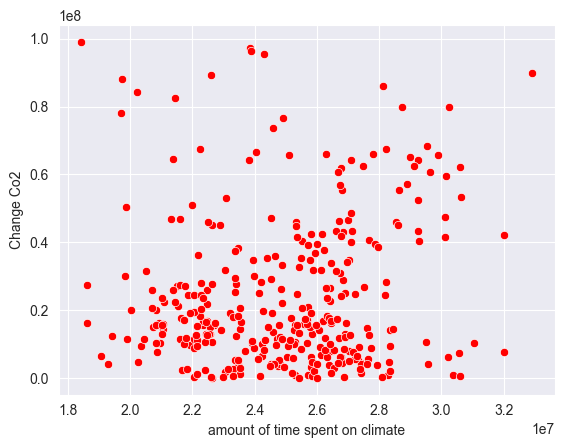

In [78]:
fig, ax = pyplot.subplots()
ax.set_xlabel("amount of time spent on climate")
ax.set_ylabel("Change Co2")
sns.scatterplot(x=predicted_outcome, y=outcome_test, c='red')
pyplot.show()